In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from numpy import random
from sklearn import svm
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from random import choice
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
from pylab import *  
from matplotlib.ticker import MultipleLocator, FormatStrFormatter  
from collections import Counter
from sklearn.calibration import CalibratedClassifierCV
%matplotlib inline

In [ ]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
train_data=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/train_data.npy")
train_label=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/train_label.npy")
test_data=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/test_data.npy")
test_label=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/test_label.npy")

##原来的标签是{-1,0,1}，现在变为三堆样本标签，正样本是0，负样本是1

In [3]:
train_label_0=np.where(train_label == 0, 0, 1)
train_label_1=np.where(train_label == 1, 0, 1)
train_label_negative1=np.where(train_label == -1, 0, 1)

##建立正负样本索引

In [4]:
train_index_0_0=[]
train_index_0_1=[]
train_index_1_0=[]
train_index_1_1=[]
train_index_negative1_0=[]
train_index_negative1_1=[]
for i in range(37367):
    if train_label_0[i] == 0:
        train_index_0_0.append(i)
    else:
        train_index_0_1.append(i)
for i in range(37367):
    if train_label_1[i] == 0:
        train_index_1_0.append(i)
    else:
        train_index_1_1.append(i)
for i in range(37367):
    if train_label_negative1[i] == 0:
        train_index_negative1_0.append(i)
    else:
        train_index_negative1_1.append(i)

##将索引随机打乱

In [5]:
np.random.shuffle(train_index_0_0)
np.random.shuffle(train_index_0_1)
np.random.shuffle(train_index_1_0)
np.random.shuffle(train_index_1_1)
np.random.shuffle(train_index_negative1_0)
np.random.shuffle(train_index_negative1_1)

#### 实现了论文中的正负索引随机分堆，共3个二分类问题，每个二分类问题正样本2堆，负样本4堆

In [6]:
train_index_0_0_1st=train_index_0_0[:int(0.5*len(train_index_0_0))]
train_index_0_0_2st=train_index_0_0[int(0.5*len(train_index_0_0)):]
train_index_0_1_1st=train_index_0_1[:int(0.25*len(train_index_0_1))]
train_index_0_1_2st=train_index_0_1[int(0.25*len(train_index_0_1)):int(0.5*len(train_index_0_1))]
train_index_0_1_3st=train_index_0_1[int(0.5*len(train_index_0_1)):int(0.75*len(train_index_0_1))]
train_index_0_1_4st=train_index_0_1[int(0.75*len(train_index_0_1)):]

train_index_1_0_1st=train_index_1_0[:int(0.5*len(train_index_1_0))]
train_index_1_0_2st=train_index_1_0[int(0.5*len(train_index_1_0)):]
train_index_1_1_1st=train_index_1_1[:int(0.25*len(train_index_1_1))]
train_index_1_1_2st=train_index_1_1[int(0.25*len(train_index_1_1)):int(0.5*len(train_index_1_1))]
train_index_1_1_3st=train_index_1_1[int(0.5*len(train_index_1_1)):int(0.75*len(train_index_1_1))]
train_index_1_1_4st=train_index_1_1[int(0.75*len(train_index_1_1)):]

train_index_negative1_0_1st=train_index_negative1_0[:int(0.5*len(train_index_negative1_0))]
train_index_negative1_0_2st=train_index_negative1_0[int(0.5*len(train_index_negative1_0)):]
train_index_negative1_1_1st=train_index_negative1_1[:int(0.25*len(train_index_negative1_1))]
train_index_negative1_1_2st=train_index_negative1_1[int(0.25*len(train_index_negative1_1)):int(0.5*len(train_index_negative1_1))]
train_index_negative1_1_3st=train_index_negative1_1[int(0.5*len(train_index_negative1_1)):int(0.75*len(train_index_negative1_1))]
train_index_negative1_1_4st=train_index_negative1_1[int(0.75*len(train_index_negative1_1)):]

##实现了论文中的正负索引组合，生成8堆混合样本

In [7]:
train_index_0_11=np.concatenate((train_index_0_0_1st,train_index_0_1_1st)) 
train_index_0_12=np.concatenate((train_index_0_0_1st,train_index_0_1_2st)) 
train_index_0_13=np.concatenate((train_index_0_0_1st,train_index_0_1_3st)) 
train_index_0_14=np.concatenate((train_index_0_0_1st,train_index_0_1_4st)) 
train_index_0_21=np.concatenate((train_index_0_0_2st,train_index_0_1_1st)) 
train_index_0_22=np.concatenate((train_index_0_0_2st,train_index_0_1_2st)) 
train_index_0_23=np.concatenate((train_index_0_0_2st,train_index_0_1_3st)) 
train_index_0_24=np.concatenate((train_index_0_0_2st,train_index_0_1_4st)) 

train_index_1_11=np.concatenate((train_index_1_0_1st,train_index_1_1_1st)) 
train_index_1_12=np.concatenate((train_index_1_0_1st,train_index_1_1_2st)) 
train_index_1_13=np.concatenate((train_index_1_0_1st,train_index_1_1_3st)) 
train_index_1_14=np.concatenate((train_index_1_0_1st,train_index_1_1_4st)) 
train_index_1_21=np.concatenate((train_index_1_0_2st,train_index_1_1_1st)) 
train_index_1_22=np.concatenate((train_index_1_0_2st,train_index_1_1_2st)) 
train_index_1_23=np.concatenate((train_index_1_0_2st,train_index_1_1_3st)) 
train_index_1_24=np.concatenate((train_index_1_0_2st,train_index_1_1_4st)) 

train_index_negative1_11=np.concatenate((train_index_negative1_0_1st,train_index_negative1_1_1st)) 
train_index_negative1_12=np.concatenate((train_index_negative1_0_1st,train_index_negative1_1_2st)) 
train_index_negative1_13=np.concatenate((train_index_negative1_0_1st,train_index_negative1_1_3st)) 
train_index_negative1_14=np.concatenate((train_index_negative1_0_1st,train_index_negative1_1_4st)) 
train_index_negative1_21=np.concatenate((train_index_negative1_0_2st,train_index_negative1_1_1st)) 
train_index_negative1_22=np.concatenate((train_index_negative1_0_2st,train_index_negative1_1_2st)) 
train_index_negative1_23=np.concatenate((train_index_negative1_0_2st,train_index_negative1_1_3st)) 
train_index_negative1_24=np.concatenate((train_index_negative1_0_2st,train_index_negative1_1_4st)) 

##为每个二分类问题建立8个分类器，一共24个SVM分类器

In [ ]:
svc_0_11=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_12=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_13=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_14=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_21=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_22=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_23=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_24=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 

svc_1_11=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_12=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_13=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_14=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_21=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_22=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_23=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_24=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 


In [55]:
svc_negative1_11=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_12=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_13=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_14=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_21=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_22=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_23=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_24=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 

##每个二分类问题训练8个分类器，一共训练24个分类器

In [46]:
svc_0_11.fit(train_data[train_index_0_11], train_label_0[train_index_0_11])
svc_0_12.fit(train_data[train_index_0_12], train_label_0[train_index_0_12])
svc_0_13.fit(train_data[train_index_0_13], train_label_0[train_index_0_13])
svc_0_14.fit(train_data[train_index_0_14], train_label_0[train_index_0_14])
svc_0_21.fit(train_data[train_index_0_21], train_label_0[train_index_0_21])
svc_0_22.fit(train_data[train_index_0_22], train_label_0[train_index_0_22])
svc_0_23.fit(train_data[train_index_0_23], train_label_0[train_index_0_23])
svc_0_24.fit(train_data[train_index_0_24], train_label_0[train_index_0_24])

CalibratedClassifierCV(base_estimator=LinearSVC(C=2e-07, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [47]:
svc_1_11.fit(train_data[train_index_1_11], train_label_1[train_index_1_11])
svc_1_12.fit(train_data[train_index_1_12], train_label_1[train_index_1_12])
svc_1_13.fit(train_data[train_index_1_13], train_label_1[train_index_1_13])
svc_1_14.fit(train_data[train_index_1_14], train_label_1[train_index_1_14])
svc_1_21.fit(train_data[train_index_1_21], train_label_1[train_index_1_21])
svc_1_22.fit(train_data[train_index_1_22], train_label_1[train_index_1_22])
svc_1_23.fit(train_data[train_index_1_23], train_label_1[train_index_1_23])
svc_1_24.fit(train_data[train_index_1_24], train_label_1[train_index_1_24])

CalibratedClassifierCV(base_estimator=LinearSVC(C=2e-07, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [56]:
svc_negative1_11.fit(train_data[train_index_negative1_11], train_label_negative1[train_index_negative1_11])
svc_negative1_12.fit(train_data[train_index_negative1_12], train_label_negative1[train_index_negative1_12])
svc_negative1_13.fit(train_data[train_index_negative1_13], train_label_negative1[train_index_negative1_13])
svc_negative1_14.fit(train_data[train_index_negative1_14], train_label_negative1[train_index_negative1_14])
svc_negative1_21.fit(train_data[train_index_negative1_21], train_label_negative1[train_index_negative1_21])
svc_negative1_22.fit(train_data[train_index_negative1_22], train_label_negative1[train_index_negative1_22])
svc_negative1_23.fit(train_data[train_index_negative1_23], train_label_negative1[train_index_negative1_23])
svc_negative1_24.fit(train_data[train_index_negative1_24], train_label_negative1[train_index_negative1_24])

CalibratedClassifierCV(base_estimator=LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

##实现min-max-modular

In [57]:
test_pred_0_11 = svc_0_11.predict_proba(test_data)[:,0]
test_pred_0_12 = svc_0_12.predict_proba(test_data)[:,0]
test_pred_0_13 = svc_0_13.predict_proba(test_data)[:,0]
test_pred_0_14 = svc_0_14.predict_proba(test_data)[:,0]
test_pred_0_21 = svc_0_21.predict_proba(test_data)[:,0]
test_pred_0_22 = svc_0_22.predict_proba(test_data)[:,0]
test_pred_0_23 = svc_0_23.predict_proba(test_data)[:,0]
test_pred_0_24 = svc_0_24.predict_proba(test_data)[:,0]

test_pred_1_11 = svc_1_11.predict_proba(test_data)[:,0]
test_pred_1_12 = svc_1_12.predict_proba(test_data)[:,0]
test_pred_1_13 = svc_1_13.predict_proba(test_data)[:,0]
test_pred_1_14 = svc_1_14.predict_proba(test_data)[:,0]
test_pred_1_21 = svc_1_21.predict_proba(test_data)[:,0]
test_pred_1_22 = svc_1_22.predict_proba(test_data)[:,0]
test_pred_1_23 = svc_1_23.predict_proba(test_data)[:,0]
test_pred_1_24 = svc_1_24.predict_proba(test_data)[:,0]

test_pred_negative1_11 = svc_negative1_11.predict_proba(test_data)[:,0]
test_pred_negative1_12 = svc_negative1_12.predict_proba(test_data)[:,0]
test_pred_negative1_13 = svc_negative1_13.predict_proba(test_data)[:,0]
test_pred_negative1_14 = svc_negative1_14.predict_proba(test_data)[:,0]
test_pred_negative1_21 = svc_negative1_21.predict_proba(test_data)[:,0]
test_pred_negative1_22 = svc_negative1_22.predict_proba(test_data)[:,0]
test_pred_negative1_23 = svc_negative1_23.predict_proba(test_data)[:,0]
test_pred_negative1_24 = svc_negative1_24.predict_proba(test_data)[:,0]

In [58]:
test_pred_0_1x=np.vstack([test_pred_0_11,test_pred_0_12,test_pred_0_13,test_pred_0_14]) #test_pred_0_1x.shape=(4, 13588)
test_pred_0_2x=np.vstack([test_pred_0_21,test_pred_0_22,test_pred_0_23,test_pred_0_24])
test_pred_1_1x=np.vstack([test_pred_1_11,test_pred_1_12,test_pred_1_13,test_pred_1_14])
test_pred_1_2x=np.vstack([test_pred_1_21,test_pred_1_22,test_pred_1_23,test_pred_1_24])
test_pred_negative1_1x=np.vstack([test_pred_negative1_11,test_pred_negative1_12,test_pred_negative1_13,test_pred_negative1_14])
test_pred_negative1_2x=np.vstack([test_pred_negative1_21,test_pred_negative1_22,test_pred_negative1_23,test_pred_negative1_24])

In [59]:
test_pred_0=[]
test_pred_1=[]
test_pred_negative1=[]
for i in range(13588):
    min_index_0_1x=int(np.where(test_pred_0_1x[:,i]==np.min(test_pred_0_1x[:,i]))[0])
    min_index_0_2x=int(np.where(test_pred_0_2x[:,i]==np.min(test_pred_0_2x[:,i]))[0])
    if test_pred_0_1x[min_index_0_1x,i] > test_pred_0_2x[min_index_0_2x,i]:
        test_pred_0.append(test_pred_0_1x[min_index_0_1x,i])
    else:
        test_pred_0.append(test_pred_0_2x[min_index_0_2x,i])
        
for i in range(13588):
    min_index_1_1x=int(np.where(test_pred_1_1x[:,i]==np.min(test_pred_1_1x[:,i]))[0])
    min_index_1_2x=int(np.where(test_pred_1_2x[:,i]==np.min(test_pred_1_2x[:,i]))[0])
    if test_pred_1_1x[min_index_1_1x,i] > test_pred_1_2x[min_index_1_2x,i]:
        test_pred_1.append(test_pred_1_1x[min_index_1_1x,i])
    else:
        test_pred_1.append(test_pred_1_2x[min_index_1_2x,i])
        
for i in range(13588):
    min_index_negative1_1x=int(np.where(test_pred_negative1_1x[:,i]==np.min(test_pred_negative1_1x[:,i]))[0])
    min_index_negative1_2x=int(np.where(test_pred_negative1_2x[:,i]==np.min(test_pred_negative1_2x[:,i]))[0])
    if test_pred_negative1_1x[min_index_negative1_1x,i] > test_pred_negative1_2x[min_index_negative1_2x,i]:
        test_pred_negative1.append(test_pred_negative1_1x[min_index_negative1_1x,i])
    else:
        test_pred_negative1.append(test_pred_negative1_2x[min_index_negative1_2x,i])

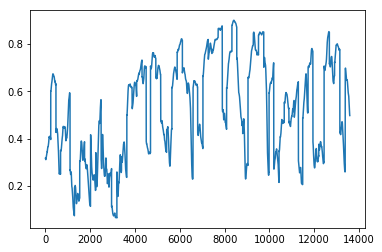

In [20]:
plot(test_pred_0)

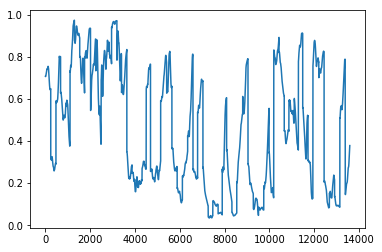

In [19]:
plot(test_pred_1)

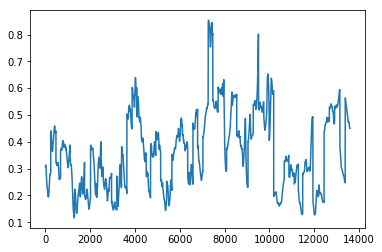

In [18]:
plot(test_pred_negative1)

In [60]:
test_pred=[]
train_pred=[]
for i in range(13588):
    maxone=max(test_pred_0[i],test_pred_1[i],test_pred_negative1[i])
    if maxone == test_pred_0[i]:
        test_pred.append(0)
    elif maxone == test_pred_1[i]:
        test_pred.append(1)
    elif maxone == test_pred_negative1[i]:
        test_pred.append(-1)

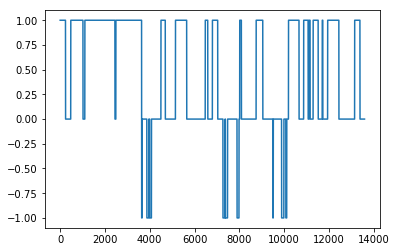

In [31]:
plot(test_pred)

In [61]:
print(accuracy_score(test_label, test_pred))

0.57300559317


In [ ]:
print(accuracy_score(train_label, train_pred))

In [62]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_label, test_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.54      0.34      0.42      4480
    class 1       0.51      0.53      0.52      4416
    class 2       0.63      0.83      0.72      4692

avg / total       0.56      0.57      0.56     13588

